# Notebook for gathering all results for ICLR Workshop
Should get results of all evals/adversarial testing for an arbitrary set of model eval functions. 

Note that some evals require TransformerLens transformers, while other evals (all generation-based ones) are faster with HuggingFace transformers. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
tokenizer.pad_token = tokenizer.eos_token

# load models
hp_model = AutoModelForCausalLM.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
regular_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
# can also load leace, other models

models = {"HP-MSR": hp_model, "LLaMA-Base": regular_model}
# will run tests on all models in this dict (and compare)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Basic Evals

## Base Replication
Use Completion-based familiarity evaluations from the paper (with the same data)

In [ ]:
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity
from datetime import datetime
save_gens = True
short = True

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-{short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

familiarity_dict = {}
for model_name, model in models.items():
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if short else 'tasks/hp/data/msr_data/evaluation_prompts.json')

    hp_familiarity_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True)
    hp_familiarity_task.run_model_evals(eval_model='gpt-3.5-turbo', max_eval_tokens=1, save_path=save_path_fn(model_name))

    familiarity, responses = hp_familiarity_task.get_accuracies()
    familiarity_dict[model_name] = familiarity

# Convert the dictionary to a pandas DataFrame
familiarity_df = pd.DataFrame(list(familiarity_dict.items()), columns=['Model', 'Familiarity'])

# Plot the bar graph
familiarity_df.plot(kind='bar', x='Model', y='Familiarity', legend=True)
plt.ylabel('Familiarity')
plt.title('Familiarity by Model')
plt.show()

## BAQ Evals
Trivia questions about Harry Potter

In [ ]:
from tasks.hp.HPTask import HPTriviaTask
hp = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

trivia_dict = {}
for model_name, model in models.items():
    hp_trivia_task = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

    trivia_dict[model_name] = hp_trivia_task.get_test_accuracy(model, use_test_data=False, check_all_logits=False, n_iters=10)

# Convert the dictionary to a pandas DataFrame
baq_df = pd.DataFrame(list(trivia_dict.items()), columns=['Model', 'Trivia'])
# Plot the bar graph
baq_df.plot(kind='bar', x='Model', y='Trivia', legend=True)
plt.ylabel('Trivia')
plt.title('Trivia by Model')
plt.show()

## SAQ Evals
Short answer questions about Harry Potter

In [ ]:
from tasks.hp.HPSAQ import HPSAQ
from datetime import datetime
save_gens = True

if save_gens:
    exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    save_path_fn = lambda model_name: f'aengus_testing/datasets/{model_name}-short-familiarity-completions-evaluated-{exp_time}.jsonl'
else:
    save_path_fn = lambda model_name: None

saq_dict = {}
for model_name, model in models.items():
    hp_saq_task = HPSAQ()

    hp_saq_task.generate_responses(model, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=True, max_new_tokens=20, temperature=0, verbose=True, eval_model='gpt-3.5-turbo')

    saq_dict[model_name] = hp_saq_task.get_accuracies() # returns dict of ["zero_shot": int, "unrelated_few_shot": int, "few_shot": int]




## Verbatim Evals
Completing sentences from Harry Potter

In [ ]:
from tasks import HPVerbatimTask
criterion = "cross_entropy"

verbatim_dict = {}
for model_name, model in models.items():
    hp_verbatim_task = HPVerbatimTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, criterion=criterion)

    verbatim_dict[model_name] = hp_verbatim_task.get_test_loss(model, n_iters=10)

# Convert the dictionary to a pandas DataFrame
verbatim_df = pd.DataFrame(list(verbatim_dict.items()), columns=['Model', 'Verbatim'])
# Plot the bar graph
verbatim_df.plot(kind='bar', x='Model', y='Verbatim', legend=True)
plt.ylabel('Verbatim')
plt.title('Verbatim by Model')
plt.show()

# Adversarial Attacks
Testing modifications to prompt and question style to see if we can get unlearned models better or base models worse

## Languages
Should test languages on familiarity evals, still in progress

## DAN Prompts
Prompts that try to trigger Harry Potter knowledge in the model without actual knowledge of Harry Potter

## In Context Relearning
Prompts that give either a summary or lines of text to the model in a system prompt to trigger Harry Pottre knowledge

## Baseline Unlearning Prompt
Prompts that try to get the model to unlearn Harry Potter knowledge

# Side Effects Evaluations
Determine if the model has gotten worse at other knowledge that is tangentially related to Harry Potter. E.g., Dungeons and Dragons, Lord of the Rings, etc.

# Eliciting Latent Knowledge
Experiments here need TransformerLens models, not HuggingFace (shouldn't be a roadblock since)

In [3]:
from transformer_lens import HookedTransformer, utils

# load models
regular_model.cpu()
hp_model.cpu()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=regular_model, device="cuda", tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)
cache_models = {"LLaMA-Base": tl_llama, "HP-MSR": tl_hp_model}

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


## Supervised Probing
Trained and tested on BAQ

### Gathering Activations

In [ ]:
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for i in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)
        sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

        for model_name, model in cache_models.items():
            with torch.no_grad():
                _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for i in range(model.cfg.n_layers):
                    if use_train:
                        train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                    else:
                        test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_resid_caches[model_name][layer] = torch.cat(train_resid_caches[model_name][layer], dim=0)
        test_resid_caches[model_name][layer] = torch.cat(test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

In [ ]:
from sklearn.linear_model import LogisticRegression
# llama_probes = []
# hp_probes = []
probes = defaultdict(list)
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe = LogisticRegression(max_iter=10000).fit(train_resid_caches[model_name][layer], train_labels)
        probes[model_name].append(probe)

In [ ]:
# train and test accuracies
# get accuracies
train_accs = defaultdict(list)
test_accs = defaultdict(list)

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        train_accs[model_name].append(probes[model_name][layer].score(train_resid_caches[model_name][layer], train_labels))
        test_accs[model_name].append(probes[model_name][layer].score(test_resid_caches[model_name][layer], test_labels))

# plot
plot_base_accs = True
if plot_base_accs:
    hp_trivia_task = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
    base_accs = {}
    for model_name, model in models.items():
        base_accs[model_name] = hp_trivia_task.get_test_accuracy(model, use_test_data=True, check_all_logits=False, n_iters=10)

for model_name in cache_models.keys():
    plt.plot(train_accs[model_name], label=f"{model_name} Train")
    plt.plot(test_accs[model_name], label=f"{model_name} Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")

plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.show()

## Unsupervised Probing
Training and measuring success of CCS Probes

### Get Contrastive Activations
Need to get activations for contrastive prompts by appending "A" and "B" to the end of the prompt

In [7]:
from tasks import HPTriviaTask
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
def resid_cache_hook(pattern, hook, layer, resid_cache):
    resid_cache[layer].append(pattern[:, -1].cpu())

a_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_train_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
train_answers = []
a_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
b_test_resid_caches = {model_name: defaultdict(list) for model_name in cache_models.keys()}
test_answers = []

resid_post_filter = lambda name: "resid_post" in name
num_train = len(hp.train_prompts)
num_test = len(hp.test_prompts)

for use_train in [True, False]:
    num_iters = num_train if use_train else num_test
    for i in tqdm(range(num_iters)):
        sample_batch = hp.get_batch(train=use_train)

        for answer in ["A", "B"]:
            prompts = [prompt + f" {answer}" for prompt in sample_batch["prompt"]]
            sample_tokens = tokenizer(prompts, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

            for model_name, model in cache_models.items():
                with torch.no_grad():
                    _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                    for i in range(model.cfg.n_layers):
                        if use_train:
                            if answer == "A":
                                a_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_train_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                        else:
                            if answer == "A":
                                a_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
                            else:
                                b_test_resid_caches[model_name][i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
        if use_train:
            train_answers.append(sample_batch["answer"][0])
        else:
            test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    for model_name in cache_models.keys():
        a_train_resid_caches[model_name][layer] = torch.cat(a_train_resid_caches[model_name][layer], dim=0)
        b_train_resid_caches[model_name][layer] = torch.cat(b_train_resid_caches[model_name][layer], dim=0)
        a_test_resid_caches[model_name][layer] = torch.cat(a_test_resid_caches[model_name][layer], dim=0)
        b_test_resid_caches[model_name][layer] = torch.cat(b_test_resid_caches[model_name][layer], dim=0)

train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


### Define and Train Probes

In [70]:
class CCSProbe(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear = torch.nn.Linear(d_model, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))

def train_ccs_probe(probe, optimizer, a_acts, b_acts, n_epochs=1000, batch_size=32):
    """
    a_acts and b_acts is tensor of shape (num_samples, d_model)
    a_acts is activations for answers with "A" as answer, b_acts is activations for answers with "B" as answer

    unsupervised probing: train a probe that maps a hidden state to a number between 0 and 1
    """
    
    # first, normalize acts by subtracting mean and dividing by std
    a_acts = (a_acts - a_acts.mean(dim=0)) / a_acts.std(dim=0)
    b_acts = (b_acts - b_acts.mean(dim=0)) / b_acts.std(dim=0)
    
    # consistency loss: make sure that the probe is consistent across the two classes
    def consistency_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        return (a_prob + b_prob - 1).pow(2).mean(dim=0)
    
    def confidence_loss(probe, a_batch, b_batch):
        """
        a_batch and b_batch are tensors of shape (b_size, d_model)
        """
        a_prob = probe(a_batch)
        b_prob = probe(b_batch)
        # loss is minimum of the two probabilities squared
        return torch.min(a_prob, b_prob).pow(2).mean(dim=0)

    # make dataloader that samples from a_acts and b_acts and cycles every epoch
    # a_loader = torch.utils.data.DataLoader(a_acts, batch_size=batch_size, shuffle=True)
    # b_loader = torch.utils.data.DataLoader(b_acts, batch_size=batch_size, shuffle=True)
    for epoch in range(n_epochs):
        # for a_batch, b_batch in zip(a_loader, b_loader):
        optimizer.zero_grad()
        # consistency = consistency_loss(probe, a_batch, b_batch)
        # confidence = confidence_loss(probe, a_batch, b_batch)
        consistency = consistency_loss(probe, a_acts, b_acts)
        confidence = confidence_loss(probe, a_acts, b_acts)
        loss = consistency + confidence
        print(f"{consistency=}, {confidence=}, {loss=}")
        loss.backward()
        optimizer.step()
    
def get_probe_prediction(probe, a_act, b_act, flip=False):
    """
    Act should be tensor of shape (d_model,), representing hidden state after prompt is "Question: ..., Answer: A"
    flip should be determined by running on a subset of data and seeing which class the probe predicts
    """
    p_ave = 1/2 * (probe(a_act) + (1 - probe(b_act)))
    p_ave = 1 - p_ave if flip else p_ave
    return "A" if p_ave > 1/2 else "B"

In [71]:
ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        optimizer = torch.optim.Adam(probe.parameters(), lr=1e-2)
        train_ccs_probe(probe, optimizer, a_train_resid_caches[model_name][layer].cuda(), b_train_resid_caches[model_name][layer].cuda(), n_epochs=1000, batch_size=num_train)
        ccs_probes[model_name][layer] = probe

  0%|          | 0/32 [00:00<?, ?it/s]

consistency=tensor([0.0599], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.2327], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.2926], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.7658], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.4269], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([1.1927], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.7097], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.3827], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([1.0924], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.6228], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.3292], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.9520], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.5247], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.2781], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.8028], device='cud

  3%|▎         | 1/32 [00:02<01:28,  2.86s/it]

consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([1.5863e-05], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([1.5844e-05], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([1.5826e-05], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([1.5808e-05], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([1.5790e-05], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([

  6%|▋         | 2/32 [00:05<01:23,  2.78s/it]

consistency=tensor([3.0564e-06], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8669e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([9.9233e-06], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([3.0528e-06], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8608e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([9.9137e-06], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([3.0493e-06], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8547e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([9.9040e-06], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([3.0458e-06], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8486e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([9.8944e-06], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([3.0422e-06], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8426e-06], device='cuda:0', gra

  9%|▉         | 3/32 [00:08<01:19,  2.73s/it]

consistency=tensor([0.0069], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0093], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0069], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0093], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0069], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0093], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0069], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0093], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0069], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0093], device='cud

 12%|█▎        | 4/32 [00:11<01:16,  2.74s/it]

consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([7.3521e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.8065e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([6.3240e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([5.9134e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([5.5710e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([

 16%|█▌        | 5/32 [00:13<01:15,  2.78s/it]

consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0046], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0046], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0046], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0046], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0046], device='cud

 19%|█▉        | 6/32 [00:16<01:12,  2.80s/it]

consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([2.7214e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([2.7135e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([2.7056e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([2.6978e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0023], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([2.6901e-06], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([

 19%|█▉        | 6/32 [00:18<01:18,  3.02s/it]

consistency=tensor([0.0046], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0070], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0046], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0070], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0046], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0070], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0046], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0070], device='cuda:0', grad_fn=<AddBackward0>)
consistency=tensor([0.0046], device='cuda:0', grad_fn=<MeanBackward1>), confidence=tensor([0.0023], device='cuda:0', grad_fn=<MeanBackward1>), loss=tensor([0.0070], device='cud

KeyboardInterrupt: 

### Get Probe Accuracies

In [65]:
# try completely randomizing probes
random_ccs_probes = {model_name: {} for model_name in cache_models.keys()}
for model_name in cache_models.keys():
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        probe = CCSProbe(tl_llama.cfg.d_model).cuda()
        random_ccs_probes[model_name][layer] = probe

randomize_probes = False
if randomize_probes:
    ccs_probes = random_ccs_probes

100%|██████████| 32/32 [00:00<00:00, 5702.41it/s]


In [68]:
flips = {model_name: {} for model_name in cache_models.keys()}
train_accuracies = {model_name: {} for model_name in cache_models.keys()}
# determine if we need to flip the probe by running on train data
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe_predictions = []
        for i in range(num_train):
            probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_train_resid_caches[model_name][layer][i].cuda(), b_train_resid_caches[model_name][layer][i].cuda(), flip=False))
        
        # get accuracy
        accuracy = (np.array(probe_predictions) == np.array(train_answers)).mean()
        flips[model_name][layer] = accuracy < 0.5
        train_accuracies[model_name][layer] = max(accuracy, 1 - accuracy)

save_models = True
# save probes and flips
if save_models and not randomize_probes:
    import pickle
    with open("models/ccs_probes.pkl", "wb") as f:
        pickle.dump((ccs_probes, flips), f)

# now get test accuracies
test_accuracies = {model_name: {} for model_name in cache_models.keys()}
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    for model_name in cache_models.keys():
        probe_predictions = []
        for i in range(num_test):
            probe_predictions.append(get_probe_prediction(ccs_probes[model_name][layer], a_test_resid_caches[model_name][layer][i].cuda(), b_test_resid_caches[model_name][layer][i].cuda(), flip=flips[model_name][layer]))
        
        # get accuracy
        test_accuracies[model_name][layer] = (np.array(probe_predictions) == np.array(test_answers)).mean()


100%|██████████| 32/32 [00:01<00:00, 17.92it/s]


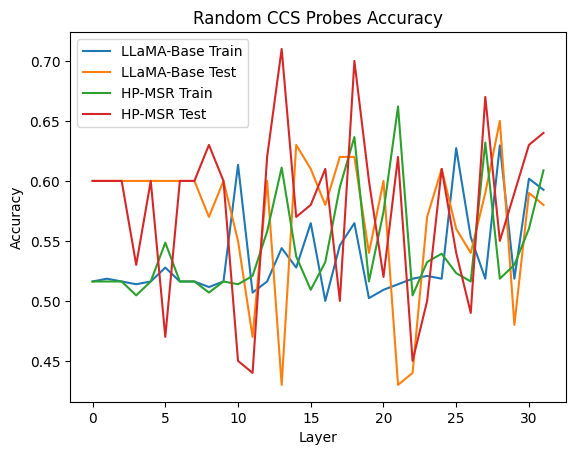

In [69]:
# plot accuracies
plot_base_accs = False
for model_name in cache_models.keys():
    plt.plot(train_accuracies[model_name].values(), label=f"{model_name} Train")
    plt.plot(test_accuracies[model_name].values(), label=f"{model_name} Test")
    if plot_base_accs:
        plt.axhline(base_accs[model_name], label=f"{model_name} Base Acc", linestyle="--")
    
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
# plt.title(f"CCS Probe Accuracy, {use_old_data=}")
plt.title("Random CCS Probes Accuracy")
plt.show()